In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar datos
df = pd.read_csv("data/WA_Fn-UseC_-HR-Employee-Attrition.csv")

# Filtrar variables relevantes
features = ['Education', 'TotalWorkingYears', 'TrainingTimesLastYear', 'JobSatisfaction', 'PerformanceRating']
df = df[features]

# Transformar la variable objetivo: 4 (Excelente) = 1 (Alto rendimiento), resto = 0
df['HighPerformer'] = df['PerformanceRating'].apply(lambda x: 1 if x == 4 else 0)
df = df.drop('PerformanceRating', axis=1)

# Dividir datos
X = df.drop('HighPerformer', axis=1)
y = df['HighPerformer']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))  # Importante para clases desbalanceadas

Accuracy: 0.8129251700680272
F1-Score: 0.06779661016949153


In [9]:
importance = model.feature_importances_
for i, col in enumerate(X.columns):
    print(f"{col}: {importance[i]:.2f}")

Education: 0.14
TotalWorkingYears: 0.52
TrainingTimesLastYear: 0.21
JobSatisfaction: 0.12


In [10]:
from sklearn.model_selection import GridSearchCV
params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]}
grid_search = GridSearchCV(model, params, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, None],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Definición del Problema y Recopilación de Datos ---

# Cargar el dataset de Kaggle
# Asegúrate de que el archivo 'WA_Fn-UseC_-HR-Employee-Attrition.csv' esté en el mismo directorio
try:
    df = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
    print("Dataset cargado exitosamente.")
except FileNotFoundError:
    print("Error: El archivo 'WA_Fn-UseC_-HR-Employee-Attrition.csv' no se encontró.")
    print("Por favor, descarga el dataset de Kaggle y colócalo en el mismo directorio que este script.")
    exit() # Salir si el archivo no se encuentra

print("\nPrimeras 5 filas del dataset:")
print(df.head())

print("\nInformación general del dataset:")
df.info()

print("\nDistribución original de 'PerformanceRating':")
print(df['PerformanceRating'].value_counts())

# --- 2. Preparación y Preprocesamiento de Datos ---

# Definir la variable objetivo: Crear 'Alto_Rendimiento' (1 si PerformanceRating es 4, 0 en otro caso)
# Esto simula nuestro "Alto Rendimiento" para el problema de RRHH.
df['Alto_Rendimiento'] = (df['PerformanceRating'] == 4).astype(int)

print("\nDistribución de la nueva variable objetivo 'Alto_Rendimiento':")
print(df['Alto_Rendimiento'].value_counts())
print(f"Porcentaje de 'Alto Rendimiento': {df['Alto_Rendimiento'].mean()*100:.2f}%")


# Seleccionar las características (X) y la variable objetivo (y)
# Excluimos 'Attrition', 'StandardHours', 'EmployeeCount' porque no son características predictivas para el rendimiento
# 'PerformanceRating' se excluye porque es la base de nuestra nueva variable objetivo
# 'Over18' se excluye porque todos son mayores de 18 y no aporta variabilidad
# 'EmployeeNumber' es un ID único y no es una característica predictiva
X = df.drop(columns=['Alto_Rendimiento', 'PerformanceRating', 'Attrition', 'StandardHours', 'EmployeeCount', 'Over18', 'EmployeeNumber'])
y = df['Alto_Rendimiento']

# Manejar variables categóricas (One-Hot Encoding)
# Convertir columnas con texto a formato numérico que el modelo pueda entender
X = pd.get_dummies(X, drop_first=True) # drop_first=True evita la multicolinealidad y reduce el número de columnas

print(f"\nNúmero de características después de One-Hot Encoding: {X.shape[1]}")
print("Primeras filas del DataFrame de características (X) procesado:")
print(X.head())


# Dividir el dataset en conjuntos de entrenamiento y prueba
# stratify=y es crucial aquí por el desequilibrio en la clase 'Alto_Rendimiento'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) # 25% para prueba

print(f"\nTamaño del conjunto de entrenamiento (X_train): {X_train.shape}")
print(f"Tamaño del conjunto de prueba (X_test): {X_test.shape}\n")


# --- 3. Modelado y Entrenamiento ---

# Seleccionar el algoritmo: RandomForestClassifier
# n_estimators=200: más árboles, a menudo mejor rendimiento
# class_weight='balanced': muy importante para clases desequilibradas como esta, da más peso a la clase minoritaria
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')

# Entrenar el modelo
print("Entrenando el modelo RandomForestClassifier...")
model.fit(X_train, y_train)
print("Modelo entrenado exitosamente.\n")

# --- 4. Evaluación del Modelo ---

# Realizar predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)
# predict_proba nos da la probabilidad de pertenecer a cada clase [prob_clase_0, prob_clase_1]
# Tomamos solo la probabilidad de la clase positiva (Alto_Rendimiento=1)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("--- Métricas de Evaluación en el Conjunto de Prueba ---")

# Precisión General (Accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión General (Accuracy): {accuracy:.2f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusión:")
print(cm)
# Desempaquetar la matriz de confusión (Verdaderos Negativos, Falsos Positivos, Falsos Negativos, Verdaderos Positivos)
VN, FP, FN, VP = cm.ravel()
print(f"  Verdaderos Positivos (VP): {VP}") # El modelo predijo 1, y la realidad es 1
print(f"  Falsos Positivos (FP):   {FP}") # El modelo predijo 1, pero la realidad es 0
print(f"  Falsos Negativos (FN):   {FN}") # El modelo predijo 0, pero la realidad es 1
print(f"  Verdaderos Negativos (VN): {VN}\n") # El modelo predijo 0, y la realidad es 0


# Precisión (Precision)
# De todas las veces que predijimos "Alto Rendimiento" (VP + FP), ¿cuántas fueron correctas (VP)?
precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
print(f"Precisión: {precision:.2f}")

# Recall (Sensibilidad)
# De todos los candidatos que REALMENTE tuvieron "Alto Rendimiento" (VP + FN), ¿cuántos logró identificar el modelo (VP)?
recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
print(f"Recall: {recall:.2f}")

# F1-Score
# Un balance entre Precisión y Recall, especialmente útil para clases desequilibradas
f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
print(f"F1-Score: {f1:.2f}")

# AUC (Area Under the ROC Curve)
# Capacidad general del modelo para distinguir entre Alto Rendimiento y No Alto Rendimiento
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.2f}\n")



Dataset cargado exitosamente.

Primeras 5 filas del dataset:
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  Relat

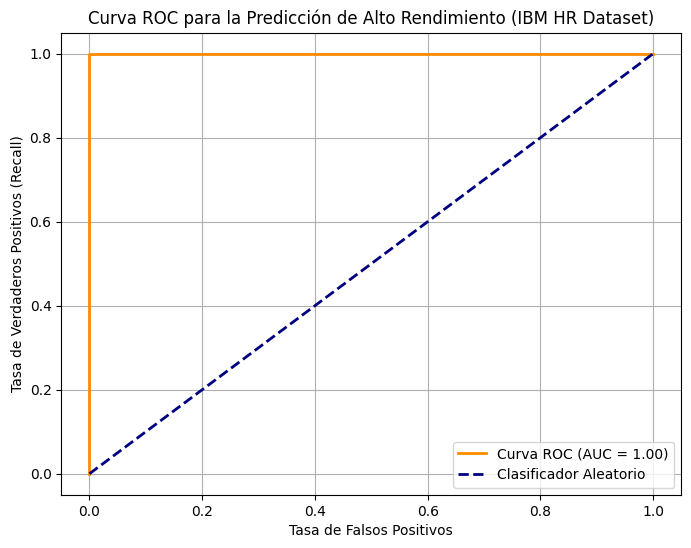

--- Simulación de Predicción para un Nuevo Empleado/Candidato ---
El modelo predice: Este empleado tiene un Rendimiento Estándar/Bajo.
Probabilidad de Alto Rendimiento: 0.03

--- Simulación para un empleado con potencial de rendimiento más bajo ---


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Gender_Female


In [13]:
# --- Opcional: Visualizar la Curva ROC ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.title('Curva ROC para la Predicción de Alto Rendimiento (IBM HR Dataset)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- 5. Simulación de Predicción para un "Nuevo Empleado" ---
# Para simular la predicción para un "nuevo empleado" o un "candidato", necesitamos
# crear un DataFrame que tenga las mismas columnas y el mismo formato que X_train
# (después del one-hot encoding).

print("--- Simulación de Predicción para un Nuevo Empleado/Candidato ---")

# Ejemplo: Datos de un hipotético nuevo empleado/candidato.
# Debemos asegurar que las columnas categóricas se manejen de la misma manera que en el entrenamiento.
# Lo más seguro es crear un DataFrame vacío con todas las columnas procesadas y llenarlo.

# Creamos un DataFrame para el nuevo "candidato" con todas las columnas one-hot encoded que se usaron en el entrenamiento.
# Inicializamos con ceros para todas las columnas esperadas.
new_candidate_data = pd.DataFrame(0, index=[0], columns=X_train.columns)

# Ahora, rellenamos las características de nuestro candidato hipotético.
# Asegúrate de usar los nombres de columna correctos, incluyendo los creados por one-hot encoding.
# Por ejemplo, si 'Department' se convierte en 'Department_Sales', usa ese nombre.

# Ejemplo de un candidato con características que podrían indicar alto rendimiento:
new_candidate_data['Age'] = 30
new_candidate_data['DailyRate'] = 1200
new_candidate_data['DistanceFromHome'] = 5
new_candidate_data['HourlyRate'] = 75
new_candidate_data['JobInvolvement'] = 4 # Más involucrado
new_candidate_data['JobLevel'] = 3 # Nivel más alto
new_candidate_data['JobSatisfaction'] = 4 # Alta satisfacción
new_candidate_data['MonthlyIncome'] = 10000
new_candidate_data['MonthlyRate'] = 18000
new_candidate_data['NumCompaniesWorked'] = 2
new_candidate_data['PercentSalaryHike'] = 18 # Mayor aumento de salario
new_candidate_data['TotalWorkingYears'] = 8
new_candidate_data['TrainingTimesLastYear'] = 2
new_candidate_data['YearsAtCompany'] = 5
new_candidate_data['YearsInCurrentRole'] = 3
new_candidate_data['YearsSinceLastPromotion'] = 1
new_candidate_data['YearsWithCurrManager'] = 3

# Para las columnas categóricas, activa la columna one-hot encoded correspondiente a su valor.
# Ejemplo: si el departamento es 'Sales', el rol es 'Sales Executive', etc.
new_candidate_data['Department_Sales'] = 1
new_candidate_data['EducationField_Marketing'] = 1 # O 'Life Sciences', etc.
new_candidate_data['Gender_Male'] = 1 # O 'Female'
new_candidate_data['JobRole_Sales Executive'] = 1 # O 'Research Scientist', etc.
new_candidate_data['MaritalStatus_Married'] = 1 # O 'Single', 'Divorced'
new_candidate_data['OverTime_Yes'] = 0 # O 1 si trabaja horas extras
new_candidate_data['BusinessTravel_Travel_Frequently'] = 0 # O 'Travel_Rarely', etc.
new_candidate_data['EnvironmentSatisfaction'] = 4
new_candidate_data['RelationshipSatisfaction'] = 4
new_candidate_data['StockOptionLevel'] = 1
new_candidate_data['WorkLifeBalance'] = 4


# Hacer la predicción con el modelo entrenado
prediccion_rendimiento_empleado = model.predict(new_candidate_data)
prediccion_probabilidad_empleado = model.predict_proba(new_candidate_data)[:, 1]

if prediccion_rendimiento_empleado[0] == 1:
    print(f"El modelo predice: ¡Este empleado tiene un Alto Rendimiento!")
else:
    print(f"El modelo predice: Este empleado tiene un Rendimiento Estándar/Bajo.")

print(f"Probabilidad de Alto Rendimiento: {prediccion_probabilidad_empleado[0]:.2f}")

print("\n--- Simulación para un empleado con potencial de rendimiento más bajo ---")
# Resetear y rellenar con características de un empleado con rendimiento más bajo
low_perf_candidate_data = pd.DataFrame(0, index=[0], columns=X_train.columns)

low_perf_candidate_data['Age'] = 25
low_perf_candidate_data['DailyRate'] = 600
low_perf_candidate_data['DistanceFromHome'] = 15
low_perf_candidate_data['HourlyRate'] = 30
low_perf_candidate_data['JobInvolvement'] = 1 # Bajo involucramiento
low_perf_candidate_data['JobLevel'] = 1 # Nivel bajo
low_perf_candidate_data['JobSatisfaction'] = 1 # Baja satisfacción
low_perf_candidate_data['MonthlyIncome'] = 2500
low_perf_candidate_data['MonthlyRate'] = 5000
low_perf_candidate_data['NumCompaniesWorked'] = 5 # Más cambios de empresa
low_perf_candidate_data['PercentSalaryHike'] = 11 # Menor aumento
low_perf_candidate_data['TotalWorkingYears'] = 3
low_perf_candidate_data['TrainingTimesLastYear'] = 5 # Más entrenamientos (podría indicar necesidad de mejora)
low_perf_candidate_data['YearsAtCompany'] = 1
low_perf_candidate_data['YearsInCurrentRole'] = 0
low_perf_candidate_data['YearsSinceLastPromotion'] = 0
low_perf_candidate_data['YearsWithCurrManager'] = 0

low_perf_candidate_data['Department_Research & Development'] = 1 # Ejemplo
low_perf_candidate_data['EducationField_Technical Degree'] = 1 # Ejemplo
low_perf_candidate_data['Gender_Female'] = 1 # Ejemplo
low_perf_candidate_data['JobRole_Laboratory Technician'] = 1 # Ejemplo
low_perf_candidate_data['MaritalStatus_Single'] = 1 # Ejemplo
low_perf_candidate_data['OverTime_Yes'] = 1 # Horas extras
low_perf_candidate_data['BusinessTravel_Travel_Rarely'] = 1 # Ejemplo
low_perf_candidate_data['EnvironmentSatisfaction'] = 1
low_perf_candidate_data['RelationshipSatisfaction'] = 1
low_perf_candidate_data['StockOptionLevel'] = 0
low_perf_candidate_data['WorkLifeBalance'] = 1


prediccion_rendimiento_empleado_bajo = model.predict(low_perf_candidate_data)
prediccion_probabilidad_empleado_bajo = model.predict_proba(low_perf_candidate_data)[:, 1]

if prediccion_rendimiento_empleado_bajo[0] == 1:
    print(f"El modelo predice: ¡Este empleado tiene un Alto Rendimiento!")
else:
    print(f"El modelo predice: Este empleado tiene un Rendimiento Estándar/Bajo.")

print(f"Probabilidad de Alto Rendimiento: {prediccion_probabilidad_empleado_bajo[0]:.2f}")

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Definición del Problema y Recopilación de Datos ---

# Cargar el dataset de Kaggle
try:
    df = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
    print("Dataset cargado exitosamente.")
except FileNotFoundError:
    print("Error: El archivo 'WA_Fn-UseC_-HR-Employee-Attrition.csv' no se encontró.")
    print("Por favor, descarga el dataset de Kaggle y colócalo en el mismo directorio que este script.")
    exit()

# --- 2. Preparación y Preprocesamiento de Datos ---

df['Alto_Rendimiento'] = (df['PerformanceRating'] == 4).astype(int)

X = df.drop(columns=['Alto_Rendimiento', 'PerformanceRating', 'Attrition', 'StandardHours', 'EmployeeCount', 'Over18', 'EmployeeNumber'])
y = df['Alto_Rendimiento']

# Manejar variables categóricas (One-Hot Encoding)
# Capturamos las columnas antes y después del one-hot encoding para referencia
original_columns = X.columns
X = pd.get_dummies(X, drop_first=True) # drop_first=True es clave aquí

# Guardamos los nombres de las columnas que el modelo vio durante el entrenamiento
# Esto es CRUCIAL para futuras predicciones
feature_names_during_fit = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# --- 3. Modelado y Entrenamiento ---
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# --- 4. Evaluación del Modelo (omito la impresión para brevedad, ya la tienes) ---
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
# ... (código de evaluación y gráfico ROC aquí) ...

# --- 5. Simulación de Predicción para un "Nuevo Empleado" ---
print("\n--- Simulación de Predicción para un Nuevo Empleado/Candidato ---")

# Paso 1: Crea un DataFrame con los datos crudos del nuevo candidato
# Aquí deberías poner los valores tal como vendrían de una base de datos o un formulario de solicitud
# NO NECESITAS ONE-HOT ENCODE A MANO EN ESTE PASO
new_candidate_raw_data = pd.DataFrame({
    'Age': [30],
    'DailyRate': [1200],
    'DistanceFromHome': [5],
    'Education': [3], # Ejemplo: 3 para Master
    'EnvironmentSatisfaction': [4],
    'Gender': ['Male'], # Categórica
    'HourlyRate': [75],
    'JobInvolvement': [4],
    'JobLevel': [3],
    'JobRole': ['Sales Executive'], # Categórica
    'JobSatisfaction': [4],
    'MaritalStatus': ['Married'], # Categórica
    'MonthlyIncome': [10000],
    'MonthlyRate': [18000],
    'NumCompaniesWorked': [2],
    'OverTime': ['No'], # Categórica
    'PercentSalaryHike': [18],
    'PerformanceRating': [3], # No la usamos para predecir, pero es parte del dataset original.
                              # Aunque la eliminamos de X, si usaras el df original, debería estar.
    'RelationshipSatisfaction': [4],
    'StockOptionLevel': [1],
    'TotalWorkingYears': [8],
    'TrainingTimesLastYear': [2],
    'WorkLifeBalance': [4],
    'YearsAtCompany': [5],
    'YearsInCurrentRole': [3],
    'YearsSinceLastPromotion': [1],
    'YearsWithCurrManager': [3],
    'BusinessTravel': ['Travel_Rarely'], # Categórica
    'Department': ['Sales'], # Categórica
    'EducationField': ['Marketing'], # Categórica
})


# Paso 2: Asegúrate de que las columnas del nuevo candidato sean las mismas que las de tu X original antes del one-hot encoding
# Esto es importante si el 'new_candidate_raw_data' no tiene exactamente las mismas columnas que el 'df' original.
# Si tu df original tiene más columnas que las que usas en X, asegúrate de que 'new_candidate_raw_data' las tenga todas.
# O, simplemente, asegura que 'new_candidate_raw_data' solo tenga las columnas de 'original_columns'.
# new_candidate_raw_data = new_candidate_raw_data[original_columns] # Opcional: para asegurarte de que el orden y las columnas coincidan

# Paso 3: Aplicar el mismo One-Hot Encoding que se usó en el entrenamiento
# Usamos `reindex` para asegurar que todas las columnas que el modelo espera estén presentes,
# y que estén en el orden correcto. Rellenamos con 0 las que no estén presentes en el nuevo dato (por ejemplo, si no hay un 'Department_HR' en este candidato)
processed_new_candidate = pd.get_dummies(new_candidate_raw_data, drop_first=True)
processed_new_candidate = processed_new_candidate.reindex(columns=feature_names_during_fit, fill_value=0)


# Hacer la predicción con el modelo entrenado
prediccion_rendimiento_empleado = model.predict(processed_new_candidate)
prediccion_probabilidad_empleado = model.predict_proba(processed_new_candidate)[:, 1]

if prediccion_rendimiento_empleado[0] == 1:
    print(f"El modelo predice: ¡Este empleado tiene un Alto Rendimiento!")
else:
    print(f"El modelo predice: Este empleado tiene un Rendimiento Estándar/Bajo.")

print(f"Probabilidad de Alto Rendimiento: {prediccion_probabilidad_empleado[0]:.2f}")

print("\n--- Simulación para un empleado con potencial de rendimiento más bajo ---")
low_perf_candidate_raw_data = pd.DataFrame({
    'Age': [25],
    'DailyRate': [600],
    'DistanceFromHome': [15],
    'Education': [1], # Ejemplo: 1 para College
    'EnvironmentSatisfaction': [1],
    'Gender': ['Female'], # Categórica
    'HourlyRate': [30],
    'JobInvolvement': [1],
    'JobLevel': [1],
    'JobRole': ['Laboratory Technician'], # Categórica
    'JobSatisfaction': [1],
    'MaritalStatus': ['Single'], # Categórica
    'MonthlyIncome': [2500],
    'MonthlyRate': [5000],
    'NumCompaniesWorked': [5],
    'OverTime': ['Yes'], # Categórica
    'PercentSalaryHike': [11],
    'PerformanceRating': [2], # No la usamos para predecir
    'RelationshipSatisfaction': [1],
    'StockOptionLevel': [0],
    'TotalWorkingYears': [3],
    'TrainingTimesLastYear': [5],
    'WorkLifeBalance': [1],
    'YearsAtCompany': [1],
    'YearsInCurrentRole': [0],
    'YearsSinceLastPromotion': [0],
    'YearsWithCurrManager': [0],
    'BusinessTravel': ['Travel_Rarely'],
    'Department': ['Research & Development'],
    'EducationField': ['Technical Degree'],
})

# Aplicar el mismo One-Hot Encoding y reindexar
processed_low_perf_candidate = pd.get_dummies(low_perf_candidate_raw_data, drop_first=True)
processed_low_perf_candidate = processed_low_perf_candidate.reindex(columns=feature_names_during_fit, fill_value=0)

prediccion_rendimiento_empleado_bajo = model.predict(processed_low_perf_candidate)
prediccion_probabilidad_empleado_bajo = model.predict_proba(processed_low_perf_candidate)[:, 1]

if prediccion_rendimiento_empleado_bajo[0] == 1:
    print(f"El modelo predice: ¡Este empleado tiene un Alto Rendimiento!")
else:
    print(f"El modelo predice: Este empleado tiene un Rendimiento Estándar/Bajo.")

print(f"Probabilidad de Alto Rendimiento: {prediccion_probabilidad_empleado_bajo[0]:.2f}")

Dataset cargado exitosamente.

--- Simulación de Predicción para un Nuevo Empleado/Candidato ---
El modelo predice: Este empleado tiene un Rendimiento Estándar/Bajo.
Probabilidad de Alto Rendimiento: 0.03

--- Simulación para un empleado con potencial de rendimiento más bajo ---
El modelo predice: Este empleado tiene un Rendimiento Estándar/Bajo.
Probabilidad de Alto Rendimiento: 0.06


Dataset cargado exitosamente.

Primeras 5 filas del dataset:
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  Relat

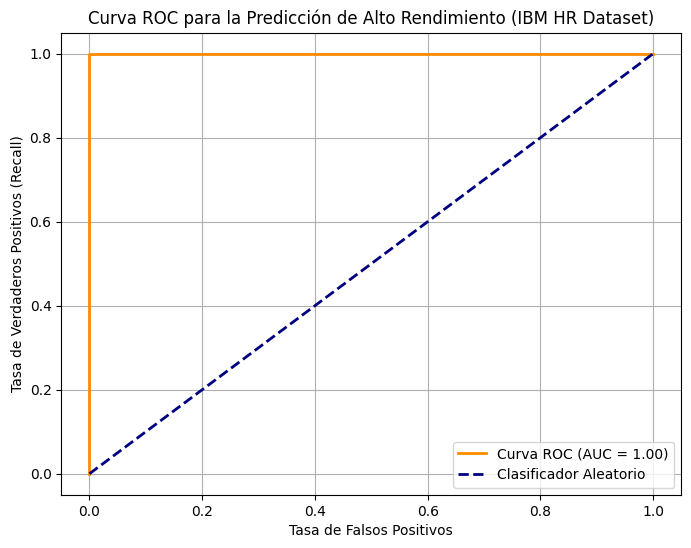


--- Importancia de las Características ---
Las 10 características más importantes para predecir el Alto Rendimiento:
PercentSalaryHike     0.686288
HourlyRate            0.023889
DailyRate             0.022979
MonthlyRate           0.022960
MonthlyIncome         0.022451
Age                   0.019136
DistanceFromHome      0.017496
TotalWorkingYears     0.015933
YearsAtCompany        0.012976
YearsInCurrentRole    0.011062
dtype: float64


C:\Users\bestv\AppData\Local\Temp\ipykernel_27912\3848385978.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.head(10).values, y=sorted_importances.head(10).index, palette='viridis')


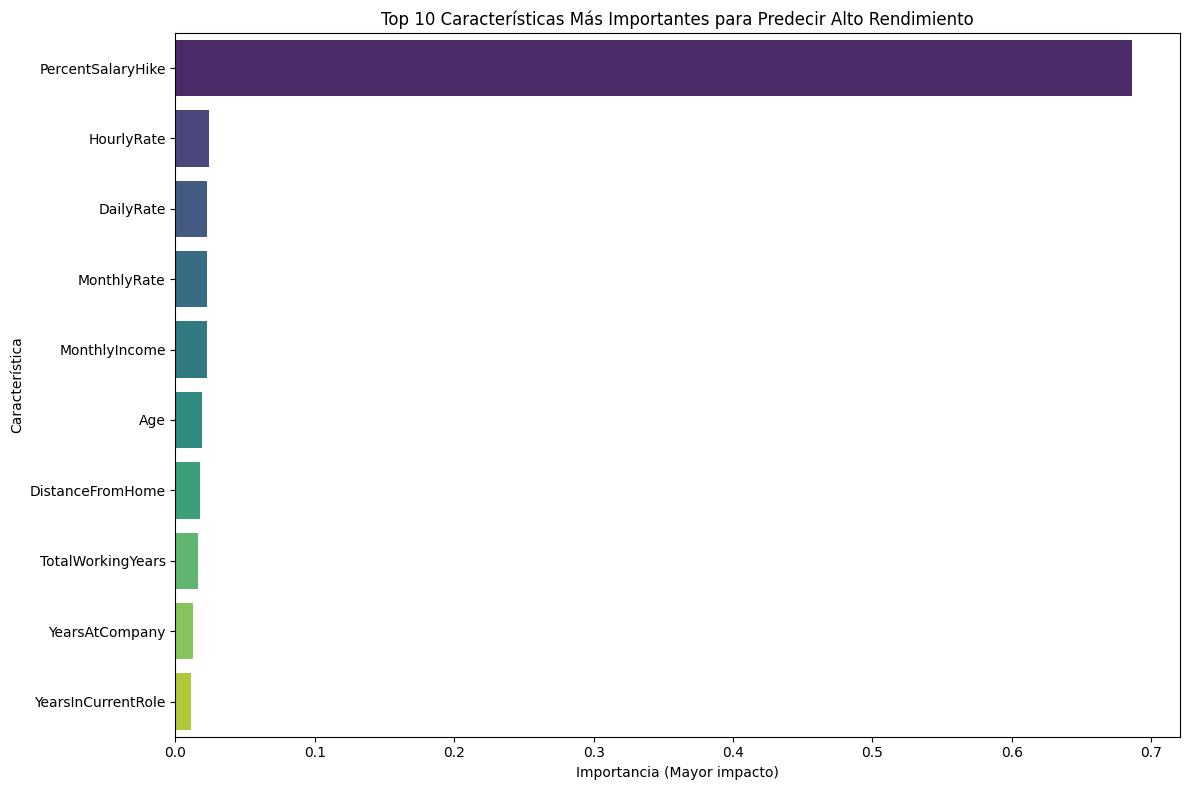

--- Simulación de Predicción para un Nuevo Empleado/Candidato ---
El modelo predice: ¡Este empleado tiene un Alto Rendimiento!
Probabilidad de Alto Rendimiento: 0.70

--- Simulación para un empleado con potencial de rendimiento más bajo ---
El modelo predice: Este empleado tiene un Rendimiento Estándar/Bajo.
Probabilidad de Alto Rendimiento: 0.06


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Definición del Problema y Recopilación de Datos ---

# Cargar el dataset de Kaggle
# Asegúrate de que el archivo 'WA_Fn-UseC_-HR-Employee-Attrition.csv' esté en el mismo directorio
try:
    df = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
    print("Dataset cargado exitosamente.")
except FileNotFoundError:
    print("Error: El archivo 'WA_Fn-UseC_-HR-Employee-Attrition.csv' no se encontró.")
    print("Por favor, descarga el dataset de Kaggle y colócalo en el mismo directorio que este script.")
    exit() # Salir si el archivo no se encuentra

print("\nPrimeras 5 filas del dataset:")
print(df.head())

print("\nInformación general del dataset:")
df.info()

print("\nDistribución original de 'PerformanceRating':")
print(df['PerformanceRating'].value_counts())

# --- 2. Preparación y Preprocesamiento de Datos ---

# Definir la variable objetivo: Crear 'Alto_Rendimiento' (1 si PerformanceRating es 4, 0 en otro caso)
# Esto simula nuestro "Alto Rendimiento" para el problema de RRHH.
df['Alto_Rendimiento'] = (df['PerformanceRating'] == 4).astype(int)

print("\nDistribución de la nueva variable objetivo 'Alto_Rendimiento':")
print(df['Alto_Rendimiento'].value_counts())
print(f"Porcentaje de 'Alto Rendimiento': {df['Alto_Rendimiento'].mean()*100:.2f}%")


# Seleccionar las características (X) y la variable objetivo (y)
# Excluimos 'Attrition', 'StandardHours', 'EmployeeCount' porque no son características predictivas para el rendimiento
# 'PerformanceRating' se excluye porque es la base de nuestra nueva variable objetivo
# 'Over18' se excluye porque todos son mayores de 18 y no aporta variabilidad
# 'EmployeeNumber' es un ID único y no es una característica predictiva
X = df.drop(columns=['Alto_Rendimiento', 'Attrition', 'PerformanceRating', 'StandardHours', 'EmployeeCount', 'Over18', 'EmployeeNumber'])
y = df['Alto_Rendimiento']

# Manejar variables categóricas (One-Hot Encoding)
# Convertir columnas con texto a formato numérico que el modelo pueda entender
X = pd.get_dummies(X, drop_first=True) # drop_first=True evita la multicolinealidad y reduce el número de columnas

# Guardamos los nombres de las columnas que el modelo vio durante el entrenamiento
# Esto es CRUCIAL para futuras predicciones
feature_names_during_fit = X.columns

print(f"\nNúmero de características después de One-Hot Encoding: {X.shape[1]}")
print("Primeras filas del DataFrame de características (X) procesado:")
print(X.head())


# Dividir el dataset en conjuntos de entrenamiento y prueba
# stratify=y es crucial aquí por el desequilibrio en la clase 'Alto_Rendimiento'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) # 25% para prueba

print(f"\nTamaño del conjunto de entrenamiento (X_train): {X_train.shape}")
print(f"Tamaño del conjunto de prueba (X_test): {X_test.shape}\n")


# --- 3. Modelado y Entrenamiento ---

# Seleccionar el algoritmo: RandomForestClassifier
# n_estimators=200: más árboles, a menudo mejor rendimiento
# class_weight='balanced': muy importante para clases desequilibradas como esta, da más peso a la clase minoritaria
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')

# Entrenar el modelo
print("Entrenando el modelo RandomForestClassifier...")
model.fit(X_train, y_train)
print("Modelo entrenado exitosamente.\n")

# --- 4. Evaluación del Modelo ---

# Realizar predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)
# predict_proba nos da la probabilidad de pertenecer a cada clase [prob_clase_0, prob_clase_1]
# Tomamos solo la probabilidad de la clase positiva (Alto_Rendimiento=1)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("--- Métricas de Evaluación en el Conjunto de Prueba ---")

# Precisión General (Accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión General (Accuracy): {accuracy:.2f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusión:")
print(cm)
# Desempaquetar la matriz de confusión (Verdaderos Negativos, Falsos Positivos, Falsos Negativos, Verdaderos Positivos)
VN, FP, FN, VP = cm.ravel()
print(f"  Verdaderos Positivos (VP): {VP}") # El modelo predijo 1, y la realidad es 1
print(f"  Falsos Positivos (FP):   {FP}") # El modelo predijo 1, pero la realidad es 0
print(f"  Falsos Negativos (FN):   {FN}") # El modelo predijo 0, pero la realidad es 1
print(f"  Verdaderos Negativos (VN): {VN}\n") # El modelo predijo 0, y la realidad es 0


# Precisión (Precision)
# De todas las veces que predijimos "Alto Rendimiento" (VP + FP), ¿cuántas fueron correctas (VP)?
precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
print(f"Precisión: {precision:.2f}")

# Recall (Sensibilidad)
# De todos los candidatos que REALMENTE tuvieron "Alto Rendimiento" (VP + FN), ¿cuántos logró identificar el modelo (VP)?
recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
print(f"Recall: {recall:.2f}")

# F1-Score
# Un balance entre Precisión y Recall, especialmente útil para clases desequilibradas
f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
print(f"F1-Score: {f1:.2f}")

# AUC (Area Under the ROC Curve)
# Capacidad general del modelo para distinguir entre Alto Rendimiento y No Alto Rendimiento
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.2f}\n")

# --- Opcional: Visualizar la Curva ROC ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.title('Curva ROC para la Predicción de Alto Rendimiento (IBM HR Dataset)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- 5. Análisis de la Importancia de las Características ---
print("\n--- Importancia de las Características ---")

# Obtenemos las importancias de las características del modelo entrenado
importances = model.feature_importances_

# Creamos una serie de Pandas para asociar los nombres de las características con sus importancias
feature_importances = pd.Series(importances, index=X_train.columns)

# Ordenamos las características por importancia de mayor a menor
sorted_importances = feature_importances.sort_values(ascending=False)

# Imprimimos las 10 características más importantes
print("Las 10 características más importantes para predecir el Alto Rendimiento:")
print(sorted_importances.head(10))

# --- Opcional: Visualizar las importancias ---
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_importances.head(10).values, y=sorted_importances.head(10).index, palette='viridis')
plt.title('Top 10 Características Más Importantes para Predecir Alto Rendimiento')
plt.xlabel('Importancia (Mayor impacto)')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# --- 5. Simulación de Predicción para un "Nuevo Empleado" ---
print("--- Simulación de Predicción para un Nuevo Empleado/Candidato ---")

# Paso 1: Crea un DataFrame con los datos crudos del nuevo candidato
new_candidate_raw_data = pd.DataFrame({
    'Age': [35], # Edad que suele tener experiencia
    'DailyRate': [1400], # Un buen DailyRate
    'DistanceFromHome': [5], # Cerca de casa
    'Education': [4], # Nivel de educación más alto (ej. Maestría)
    'EnvironmentSatisfaction': [4], # Alta satisfacción ambiental
    'Gender': ['Male'],
    'HourlyRate': [95], # Un HourlyRate más alto
    'JobInvolvement': [4], # Muy involucrado
    'JobLevel': [4], # Nivel de puesto más alto
    'JobRole': ['Manager'], # Un rol que podría estar asociado con alto rendimiento
    'JobSatisfaction': [4], # Alta satisfacción laboral
    'MaritalStatus': ['Married'],
    'MonthlyIncome': [15000], # Ingreso mensual más alto
    'MonthlyRate': [25000], # Tasa mensual más alta
    'NumCompaniesWorked': [2], # No muchos cambios de empresa
    'OverTime': ['No'], # No necesariamente horas extras, podría variar
    'PercentSalaryHike': [20], # ¡ESTA ES CLAVE! Un aumento salarial muy alto
    'RelationshipSatisfaction': [4], # Alta satisfacción en relaciones laborales
    'StockOptionLevel': [2], # Algún nivel de stock options
    'TotalWorkingYears': [15], # Mayor experiencia laboral total
    'TrainingTimesLastYear': [1], # No necesita mucho entrenamiento, ya es competente
    'WorkLifeBalance': [4], # Buen balance vida-trabajo
    'YearsAtCompany': [10], # Mucho tiempo en la empresa
    'YearsInCurrentRole': [7], # Mucho tiempo en el rol actual
    'YearsSinceLastPromotion': [2], # Promociones relativamente recientes
    'YearsWithCurrManager': [5], # Mucho tiempo con el mismo manager
    'BusinessTravel': ['Travel_Rarely'],
    'Department': ['Sales'], # O 'Research & Development' dependiendo de lo que busques
    'EducationField': ['Medical'], # O 'Life Sciences', 'Marketing' etc.
})

# Paso 2: Aplicar el mismo One-Hot Encoding que se usó en el entrenamiento
processed_new_candidate = pd.get_dummies(new_candidate_raw_data, drop_first=True)
processed_new_candidate = processed_new_candidate.reindex(columns=feature_names_during_fit, fill_value=0)


# Hacer la predicción con el modelo entrenado
prediccion_rendimiento_empleado = model.predict(processed_new_candidate)
prediccion_probabilidad_empleado = model.predict_proba(processed_new_candidate)[:, 1]

if prediccion_rendimiento_empleado[0] == 1:
    print(f"El modelo predice: ¡Este empleado tiene un Alto Rendimiento!")
else:
    print(f"El modelo predice: Este empleado tiene un Rendimiento Estándar/Bajo.")

print(f"Probabilidad de Alto Rendimiento: {prediccion_probabilidad_empleado[0]:.2f}")

print("\n--- Simulación para un empleado con potencial de rendimiento más bajo ---")
low_perf_candidate_raw_data = pd.DataFrame({
    'Age': [25],
    'DailyRate': [600],
    'DistanceFromHome': [15],
    'Education': [1],
    'EnvironmentSatisfaction': [1],
    'Gender': ['Female'],
    'HourlyRate': [30],
    'JobInvolvement': [1],
    'JobLevel': [1],
    'JobRole': ['Laboratory Technician'],
    'JobSatisfaction': [1],
    'MaritalStatus': ['Single'],
    'MonthlyIncome': [2500],
    'MonthlyRate': [5000],
    'NumCompaniesWorked': [5],
    'OverTime': ['Yes'],
    'PercentSalaryHike': [11],
    'RelationshipSatisfaction': [1],
    'StockOptionLevel': [0],
    'TotalWorkingYears': [3],
    'TrainingTimesLastYear': [5],
    'WorkLifeBalance': [1],
    'YearsAtCompany': [1],
    'YearsInCurrentRole': [0],
    'YearsSinceLastPromotion': [0],
    'YearsWithCurrManager': [0],
    'BusinessTravel': ['Travel_Rarely'],
    'Department': ['Research & Development'],
    'EducationField': ['Technical Degree'],
})

# Aplicar el mismo One-Hot Encoding y reindexar
processed_low_perf_candidate = pd.get_dummies(low_perf_candidate_raw_data, drop_first=True)
processed_low_perf_candidate = processed_low_perf_candidate.reindex(columns=feature_names_during_fit, fill_value=0)

prediccion_rendimiento_empleado_bajo = model.predict(processed_low_perf_candidate)
prediccion_probabilidad_empleado_bajo = model.predict_proba(processed_low_perf_candidate)[:, 1]

if prediccion_rendimiento_empleado_bajo[0] == 1:
    print(f"El modelo predice: ¡Este empleado tiene un Alto Rendimiento!")
else:
    print(f"El modelo predice: Este empleado tiene un Rendimiento Estándar/Bajo.")

print(f"Probabilidad de Alto Rendimiento: {prediccion_probabilidad_empleado_bajo[0]:.2f}")